In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import random
from datetime import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

*Заметка: не забыть про возможность уменьшения размерности данных (занятие web3)*

### **EDA**

In [7]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
# Номинативные переменные
# ! различные виды id это тоже номинативный признак

train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [9]:
# Количественные переменные
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


*если count меньше 10000 -> есть NaN значения*

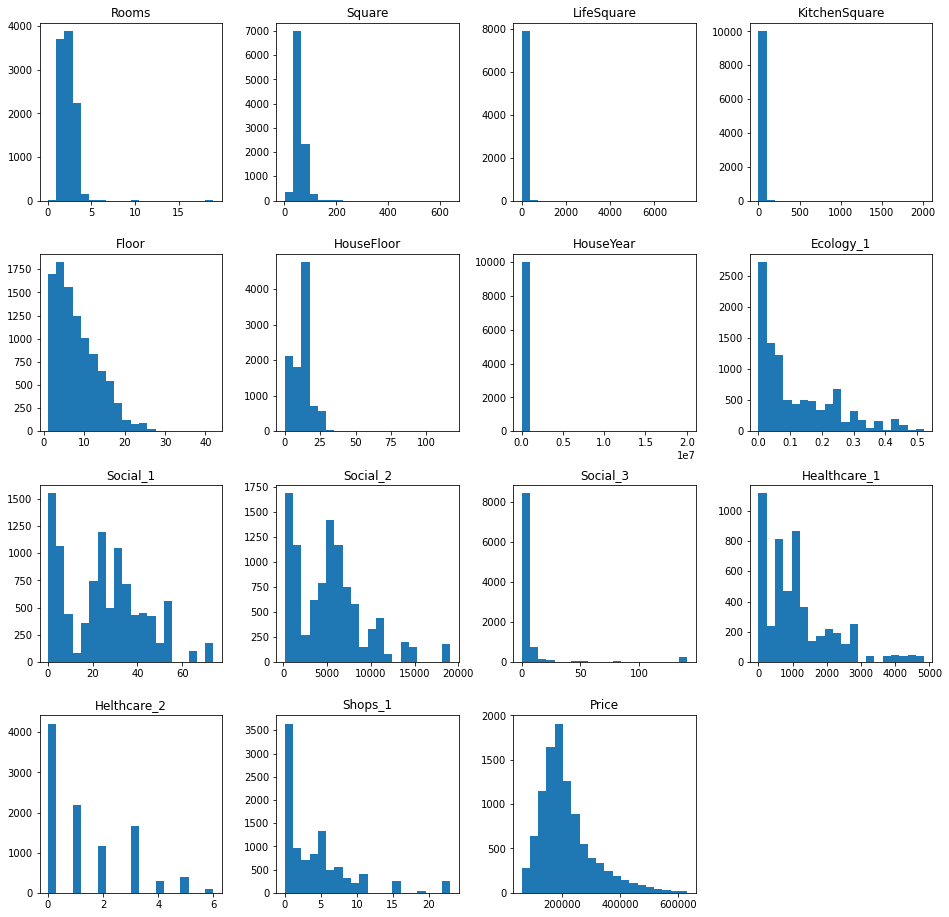

In [10]:
train_df.hist(figsize=(16, 16), bins=20, grid=False);
# ';' в конце ставится чтоб не вылезали описания плотов

### **Обработка пропусков**

In [11]:
# Для изучения признаков
# 1 .value_counts()

train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [12]:
# 2 .sort_values().unique()

train_df['Healthcare_1'].sort_values().unique()

array([   0.,   30.,   32.,   35.,   46.,   75.,   80.,  100.,  125.,
        145.,  165.,  176.,  192.,  200.,  229.,  240.,  262.,  320.,
        325.,  350.,  370.,  520.,  540.,  562.,  620.,  628.,  645.,
        705.,  730.,  750.,  770.,  800.,  810.,  830.,  900.,  920.,
        990., 1015., 1020., 1036., 1046., 1084., 1130., 1145., 1183.,
       1308., 1322., 1340., 1406., 1430., 1450., 1547., 1548., 1575.,
       1786., 1815., 1894., 1937., 1940., 1970., 1994., 2078., 2300.,
       2301., 2500., 2620., 2643., 2672., 2715., 2729., 2857., 2890.,
       3300., 3855., 4087., 4129., 4508., 4702., 4849.,   nan])

In [13]:
# 3 quantile для определения границ

train_df['Healthcare_1'].quantile(.025), train_df['Healthcare_1'].quantile(.975)

(30.0, 4087.0)

In [14]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # будем отталкиваться от факта что 0 это пропущенное значение и заменим его на медиану
        
        X.loc[X['Healthcare_1'] == 0, 'Healthcare_1'] = self.medians['Healthcare_1']
        X.loc[X['Ecology_1'] == 0, 'Ecology_1'] = self.medians['Ecology_1']
        X.loc[X['Shops_1'] == 0, 'Shops_1'] = self.medians['Shops_1']
        X.loc[X['Social_1'] == 0, 'Social_1'] = self.medians['Social_1']
        X.loc[X['Social_2'] == 0, 'Social_2'] = self.medians['Social_2']
        X.loc[X['Social_3'] == 0, 'Social_3'] = self.medians['Social_3']
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [15]:
dp = DataPreprocessing()

dp.fit(train_df)
train_df = dp.transform(train_df)

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,2,900.0,0,3,B,305018.871089,0,0,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,3,B,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,2,240.0,3,1,B,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,2,900.0,0,1,B,168106.007630,0,0,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,B,343995.102962,0,0,0,0


In [16]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
dtype: int64

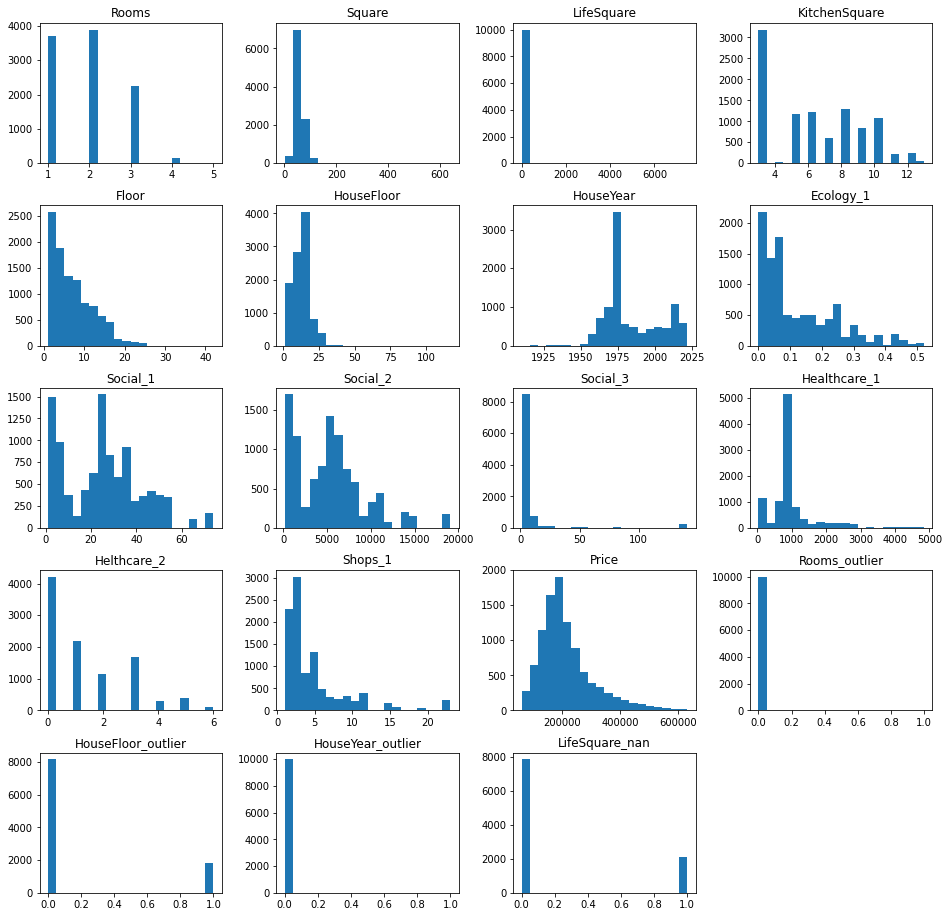

In [17]:
train_df.hist(figsize=(16, 16), bins=20, grid=False);

### **Создание новых признаков**

In [18]:
class FeatureGenerator:
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_hc = None
        self.med_price_by_sc = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        
        df = X.copy()
        
        #if y is not None:
        #    df['Price'] = y.values
            
        #    self.med_price_by_district = df.groupby(['DistrictId', 'Social_1'], as_index=False).agg({'Price':'median'})\
        #                                   .rename(columns={'Price':'MedPriceByDistrict'})
            
        #    self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
        ## HealthCare
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_hc = df.groupby(['Helthcare_2', 'Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                    .rename(columns={'Price':'MedPriceByHealthcare'})
            self.med_price_by_hc_median = self.med_price_by_hc['MedPriceByHealthcare'].median()
            
        ## Social
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_sc = df.groupby(['Social_1', 'Social_2', 'Social_3', 'Shops_1'], as_index=False).agg({'Price':'median'})\
                                    .rename(columns={'Price':'MedPriceBySocial'})
            self.med_price_by_sc_median = self.med_price_by_sc['MedPriceBySocial'].median()

        
    def transform(self, X):
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        #X['new_district'] = 0
        #X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features (я решила повторить такие признаки потому что модель обращает алалаллалала допишу потом)
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        # Target encoding
        #if self.med_price_by_district is not None:
        #    X = X.merge(self.med_price_by_district, on=['DistrictId', 'Social_1'], how='left')
        #    X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        if self.med_price_by_hc is not None:
            X = X.merge(self.med_price_by_hc, on=['Helthcare_2', 'Social_1', 'Social_2'], how='left')
            X['MedPriceByHealthcare'].fillna(self.med_price_by_hc_median, inplace=True)
            
        if self.med_price_by_sc is not None:
            X = X.merge( self.med_price_by_sc, on=['Social_1', 'Social_2', 'Social_3', 'Shops_1'], how='left')
            X['MedPriceBySocial'].fillna(self.med_price_by_sc_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        # если в границы bins передать переменные self. выдаст ошибку (воспринимает их как None)
        # пробовала передать .self как переменные функции но питон всё равно их игнорирует
        bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [20]:
fg = FeatureGenerator()

fg.fit(train_df)
train_df = fg.transform(train_df)

# дублирую тут код тк он заточен на разбитую выборку (в общем, насколько я помню, проблема в условии y=None is not
# True, из-за чего класс не мерджит столбцы, хотя по-моему я для эксперимента убирала это условие и признаки всё
# равно не добавились..)))

# MedPriceByDistrict
# в классе убрала потому что модель очень большой процент важности отдаёт, без него лучше
med_price_by_district = train_df.groupby(['DistrictSize', 'Social_1'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
            
med_price_by_district_median = med_price_by_district['MedPriceByDistrict'].median()

# MedPriceByFloorYear
floor_max = train_df['Floor'].max()
floor_min = train_df['Floor'].min()
house_year_max = train_df['HouseYear'].max()
house_year_min = train_df['HouseYear'].min()
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year_median = med_price_by_floor_year['MedPriceByFloorYear'].median()

# MedPriceByHealthcare
med_price_by_hc = train_df.groupby(['Helthcare_2', 'Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                .rename(columns={'Price':'MedPriceByHealthcare'})
med_price_by_hc_median = med_price_by_hc['MedPriceByHealthcare'].median()
            

# MedPriceBySocial
med_price_by_sc = train_df.groupby(['Social_1', 'Social_2', 'Social_3', 'Shops_1'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceBySocial'})
med_price_by_sc_median = med_price_by_sc['MedPriceBySocial'].median()

# Merge
train_df = train_df.merge(med_price_by_district, on=['DistrictSize', 'Social_1'], how='left')
train_df['MedPriceByDistrict'].fillna(med_price_by_district_median, inplace=True)
            
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df['MedPriceByFloorYear'].fillna(med_price_by_floor_year_median, inplace=True)
            
train_df = train_df.merge(med_price_by_hc, on=['Helthcare_2', 'Social_1', 'Social_2'], how='left')
train_df['MedPriceByHealthcare'].fillna(med_price_by_hc_median, inplace=True)
            
train_df = train_df.merge( med_price_by_sc, on=['Social_1', 'Social_2', 'Social_3', 'Shops_1'], how='left')
train_df['MedPriceBySocial'].fillna(med_price_by_sc_median, inplace=True)


train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,MedPriceByHealthcare,MedPriceBySocial
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,851,1,1.0,5.0,148315.419074,162865.148671,148315.419074,148315.419074
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,78,0,2.0,2.0,186161.900526,191875.000849,186809.604691,186809.604691
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,652,1,0.0,3.0,203858.095745,205210.068542,205993.377137,205993.377137
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,652,1,3.0,2.0,183882.806975,183445.443721,183882.806975,183882.806975
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,89,0,4.0,2.0,201584.441255,171931.149112,203153.518639,203153.518639


### **Отбор признаков**

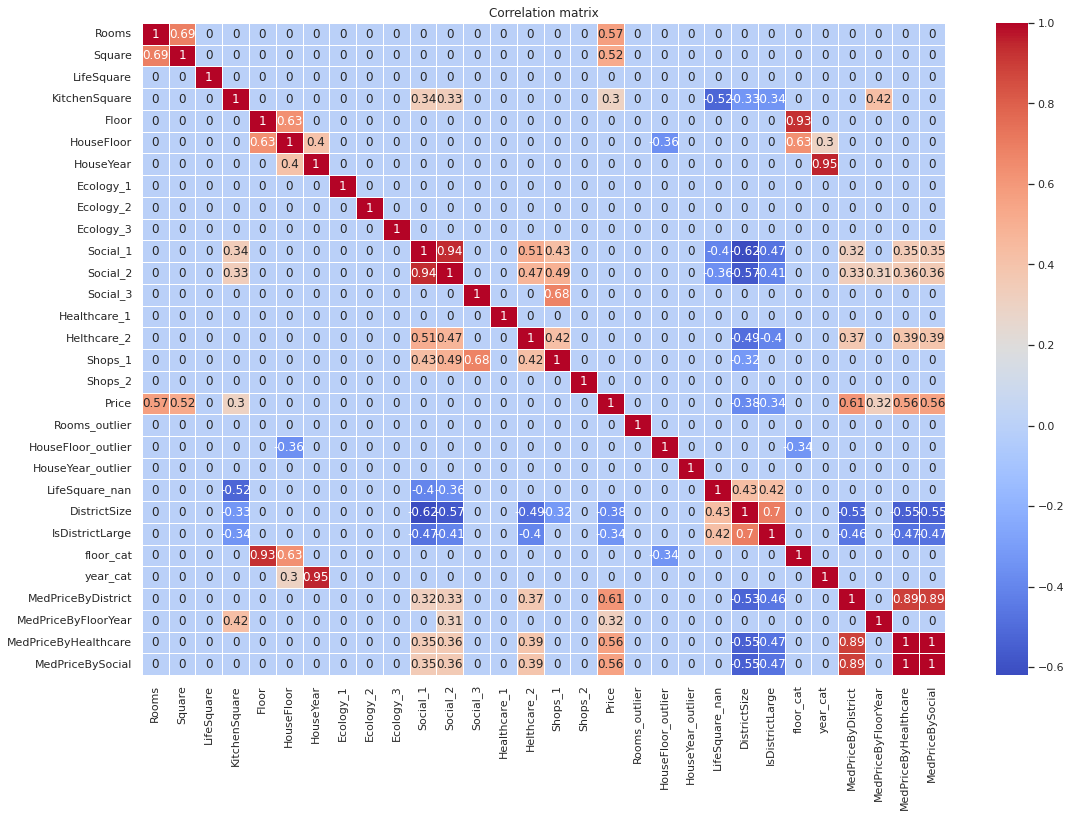

In [21]:
# Корреляция признаков

plt.figure(figsize=(18, 12))

sns.set(font_scale=1)

corr_X = train_df.corr()
corr_X = np.round(corr_X, 2)
corr_X[np.abs(corr_X) < 0.3] = 0

sns.heatmap(corr_X, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [22]:
# кстати в названиях стобиков опечатка - Healthcare и Helthcare

feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'IsDistrictLarge', 'MedPriceByFloorYear', 'MedPriceByHealthcare',
                     'MedPriceBySocial']

target_name = 'Price'

### **Разбиение на train и test**

In [23]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [24]:
# Не забыть позже разобраться с ошибкой (то же выдает и в FeatureGenerator):
# /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns
# in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError. 
# Select only valid columns before calling the reduction.
#   if sys.path[0] == '':
# /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead

dp_2 = DataPreprocessing()
dp_2.fit(X_train)

X_train = dp_2.transform(X_train)
X_valid = dp_2.transform(X_valid)
test_df = dp_2.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [25]:
fg_2 = FeatureGenerator()
fg_2.fit(X_train, y_train)

X_train = fg_2.transform(X_train)
X_valid = fg_2.transform(X_valid)
test_df = fg_2.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [26]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [27]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

### **Обучение модели**

In [28]:
def evaluate_preds(true_val, pred_val, Save=False):
    print("R2:\t" + str(round(r2(true_val, pred_val), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_val, pred_val)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_val, pred_val), 3))
         )
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_val, y=true_val)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('True vs Predicted values')
    
    if Save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    
    plt.show

In [29]:
# Одновременная визуализация train и test результатов:

# def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
#     print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
#     print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
#     plt.figure(figsize=(18,10))
    
#     plt.subplot(121)
#     sns.scatterplot(x=train_pred_values, y=train_true_values)
#     plt.xlabel('Predicted values')
#     plt.ylabel('True values')
#     plt.title('Train sample prediction')
    
#     plt.subplot(122)
#     sns.scatterplot(x=test_pred_values, y=test_true_values)
#     plt.xlabel('Predicted values')
#     plt.ylabel('True values')
#     plt.title('Test sample prediction')

#     plt.show()

R2:	0.736
RMSE:	47847.389
MSE:	2289372667.925


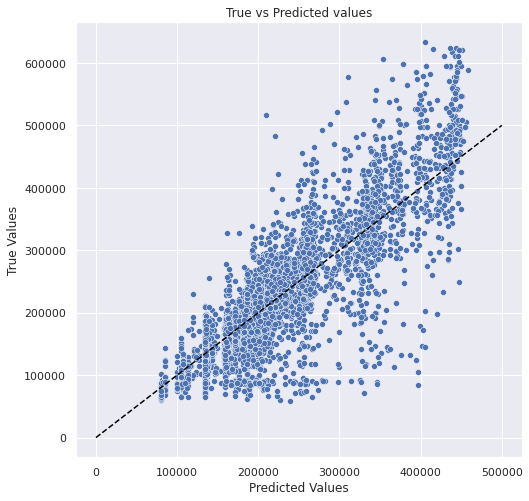

In [30]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=100)
model.fit(X_train, y_train)
y_pred_forest = model.predict(X_train)

evaluate_preds(y_train, y_pred_forest)

R2:	0.689
RMSE:	51432.025
MSE:	2645253192.937


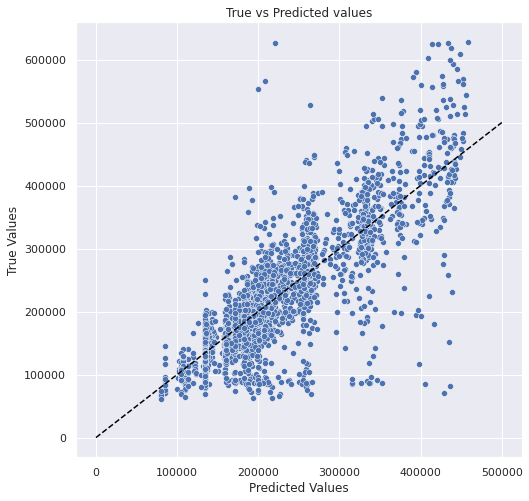

In [31]:
y_pred_forest = model.predict(X_valid)

evaluate_preds(y_valid, y_pred_forest)

In [74]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     random_state=65,
                                     # n_estimators=100,
                                     # max_depth=7
                                     )

In [75]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: user 3.35 s, sys: 134 ms, total: 3.49 s
Wall time: 2min 40s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=65),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [76]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [77]:
gs.best_score_

0.7442049846447001

R2:	0.835
RMSE:	37908.655
MSE:	1437066138.952


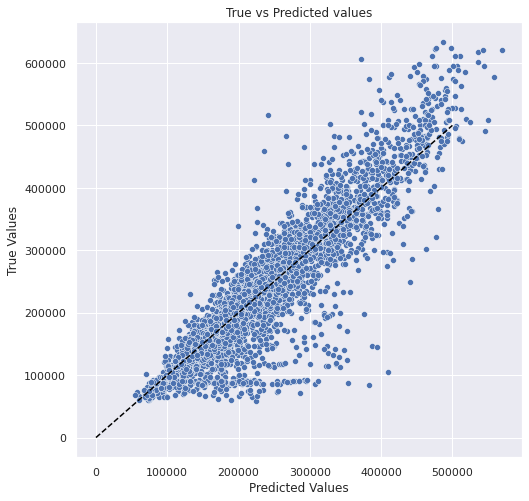

In [40]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=30,
                                        random_state=100,
                                        n_estimators=100)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.733
RMSE:	47607.375
MSE:	2266462184.49


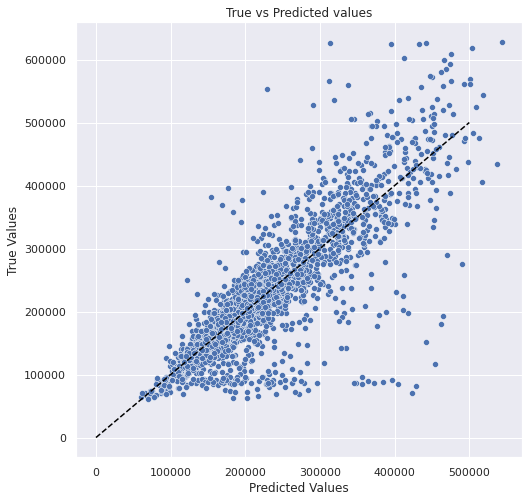

In [41]:
y_test_preds = final_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

In [42]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.462326
24,MedPriceByHealthcare,0.190939
25,MedPriceBySocial,0.134639
21,DistrictSize,0.060889
23,MedPriceByFloorYear,0.029320
0,Rooms,0.027632
12,Social_3,0.018619
6,HouseYear,0.012617
2,LifeSquare,0.012362
3,KitchenSquare,0.009304


### **Сдаём результаты**

In [43]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByFloorYear,MedPriceByHealthcare,MedPriceBySocial
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,73.0,0,187640.182751,203166.879786,203166.879786
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,169.0,1,171582.695618,166329.087983,166329.087983
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,1,578.0,1,168600.632600,114543.386893,114543.386893
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,400.0,1,182528.188813,110267.074912,110267.074912
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,1,77.0,0,190243.102889,187656.177472,187656.177472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,1,1,...,1,0,1,0,0,69.0,0,187640.182751,180611.298860,180611.298860
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,23.0,0,206083.505698,263610.596640,263610.596640
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,67.0,0,182528.188813,193398.221967,193398.221967
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,39.0,0,190243.102889,220082.015992,220082.015992


In [44]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [45]:
predictions = final_model.predict(test_df)
predictions

array([163612.14491046, 134427.84914208, 148093.45528502, ...,
       147016.47227384, 194737.65833601, 259609.03791121])

In [46]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163612.144910
1,5925,134427.849142
2,960,148093.455285
3,3848,114009.145052
4,746,192032.522409


In [47]:
submit.to_csv('rf_submit.csv', index=False)